/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-9d4cdb191354>:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode 1/300, Reward: 9.0
Episode 2/300, Reward: 11.0
Episode 3/300, Reward: 10.0
Episode 4/300, Reward: 10.0
Episode 5/300, Reward: 9.0
Episode 6/300, Reward: 9.0
Episode 7/300, Reward: 10.0
Episode 8/300, Reward: 10.0
Episode 9/300, Reward: 10.0
Episode 10/300, Reward: 11.0
Episode 11/300, Reward: 8.0
Episode 12/300, Reward: 9.0
Episode 13/300, Reward: 9.0
Episode 14/300, Reward: 9.0
Episode 15/300, Reward: 10.0
Episode 16/300, Reward: 9.0
Episode 17/300, Reward: 10.0
Episode 18/300, Reward: 9.0
Episode 19/300, Reward: 10.0
Episode 20/300, Reward: 9.0
Episode 21/300, Reward: 11.0
Episode 22/300, Reward: 8.0
Episode 23/300, Reward: 8.0
Episode 24/300, Reward: 9.0
Episode 25/300, Reward: 9.0
Episode 26/300, Reward: 10.0
Episode 27/300, Reward: 10.0
Episode 28/300, Reward: 9.0
Episode 29/300, Reward: 9.0
Episode 30/300, Reward: 10.0
Episode 31/300, Reward: 10.0
Episode 32/300, Reward: 10.0
Episode 33/300, Reward: 9.0
Episode 34/300, Reward: 10.0
Episode 35/300, Reward: 9.0
Episode 36/3

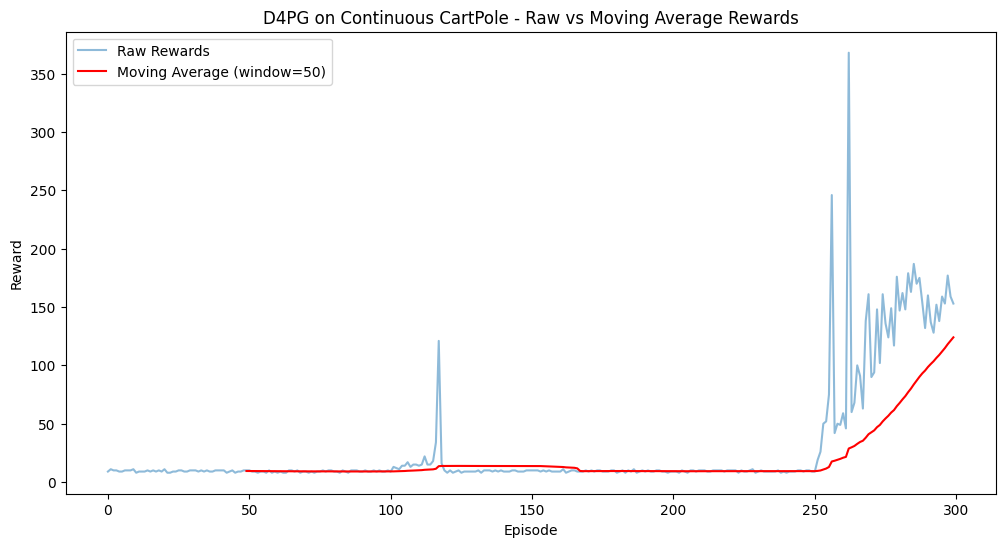

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Custom wrapper for continuous CartPole
class ContinuousCartPoleWrapper(gym.Env):
    def __init__(self, env):
        self.env = env
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = self.env.observation_space

    def step(self, action):
        discrete_action = 0 if action < 0.5 else 1
        obs, reward, done, info = self.env.step(discrete_action)
        return obs, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()


# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Logistic output
        )

    def forward(self, state):
        return self.net(state)


# Define the Distributional Critic Network
class DistributionalCritic(nn.Module):
    def __init__(self, state_dim, action_dim, atoms, v_min, v_max):
        super(DistributionalCritic, self).__init__()
        self.atoms = atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (atoms - 1)
        self.support = torch.linspace(v_min, v_max, atoms)
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, atoms),
        )

    def forward(self, state, action):
        q_values = self.net(torch.cat([state, action], dim=1))
        probs = torch.softmax(q_values, dim=1)  # Distributional output
        return probs

    def get_q_value(self, probs):
        return torch.sum(probs * self.support, dim=1, keepdim=True)


# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)


# Projection for Distributional Critic
def project_distribution(probs, rewards, dones, gamma, atoms, v_min, v_max, delta_z, batch_size):
    target_support = torch.linspace(v_min, v_max, atoms)
    projected_probs = torch.zeros((batch_size, atoms), dtype=torch.float32)

    for i in range(batch_size):
        tz = rewards[i] + gamma * (1 - dones[i]) * target_support
        tz = torch.clamp(tz, v_min, v_max)
        b = (tz - v_min) / delta_z
        l = b.floor().long()
        u = b.ceil().long()

        for j in range(atoms):
            if l[j] == u[j]:
                projected_probs[i, l[j]] += probs[i, j]
            else:
                projected_probs[i, l[j]] += probs[i, j] * (u[j] - b[j])
                projected_probs[i, u[j]] += probs[i, j] * (b[j] - l[j])

    return projected_probs


# Train the D4PG agent
def train_d4pg(env, actor, critic, target_actor, target_critic, buffer, actor_optimizer, critic_optimizer, n_episodes=300, batch_size=64):
    gamma = 0.99
    tau = 0.005  # Soft update parameter
    rewards = []
    atoms = critic.atoms
    v_min = critic.v_min
    v_max = critic.v_max
    delta_z = critic.delta_z

    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = actor(state_tensor).detach().numpy()[0]
            next_state, reward, done, _ = env.step(action)
            buffer.add((state, action, reward, next_state, done))

            if buffer.size() > batch_size:
                # Sample from buffer
                states, actions, rewards_batch, next_states, dones = buffer.sample(batch_size)

                # Update Critic
                target_actions = target_actor(next_states)
                target_probs = target_critic(next_states, target_actions).detach()
                projected_probs = project_distribution(
                    target_probs, rewards_batch, dones, gamma, atoms, v_min, v_max, delta_z, batch_size
                )
                critic_probs = critic(states, actions)
                critic_loss = -torch.sum(projected_probs * torch.log(critic_probs + 1e-6), dim=1).mean()
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update Actor
                actor_loss = -critic.get_q_value(critic(states, actor(states))).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Soft update of target networks
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            state = next_state
            episode_reward += reward
            if done:
                break

        rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{n_episodes}, Reward: {episode_reward}")

    return rewards


# Function to calculate moving average
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


# Main
env = ContinuousCartPoleWrapper(gym.make("CartPole-v1"))

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
atoms = 51
v_min = 0  # Rescaled to match CartPole rewards
v_max = 500  # Rescaled to match CartPole rewards

actor = Actor(state_dim, action_dim)
critic = DistributionalCritic(state_dim, action_dim, atoms, v_min, v_max)
target_actor = Actor(state_dim, action_dim)
target_critic = DistributionalCritic(state_dim, action_dim, atoms, v_min, v_max)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)

buffer = ReplayBuffer(capacity=100000)

# Train the D4PG agent and get rewards
rewards = train_d4pg(env, actor, critic, target_actor, target_critic, buffer, actor_optimizer, critic_optimizer)

# Calculate moving average rewards
window_size = 50
smoothed_rewards = moving_average(rewards, window_size)

# Plot raw rewards and moving average
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Raw Rewards", alpha=0.5)
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f"Moving Average (window={window_size})", color="red")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("D4PG on Continuous CartPole - Raw vs Moving Average Rewards")
plt.legend()
plt.show()
